# **Predicting Admission into University of Texas at Austin's Data Science Masters Program**

In this project, I built a Random Forest Classifier to predict whether an applicant will get accepted into The University of Texas at Austin's masters of science in data science program.

**Data source:** The unofficial subreddit for the University of Texas at Austin Master of Science in Data Science (Option III) program admissions thread: https://www.reddit.com/r/MSDSO/?f=flair_name%3A%22Admissions%20Thread%22

# Data Preprocessing

In [74]:
# Import Dependencies
import pandas as pd
import json
import glob

In [75]:
# Import dataset, JSON
dataset_path = '/kaggle/input/msdo-ut-austin-survey/ALLsemesters.json'
df = pd.read_json(dataset_path)

# Preliminary cleaning
df.drop('toeflScore', axis=1, inplace=True)

# Extract information
extract_education = lambda x, field: x[field] if isinstance(x, dict) and field in x else None
df['institution'] = df['education'].apply(extract_education, args=('institution',))
df['degree'] = df['education'].apply(extract_education, args=('degree',))
df['gpa'] = df['education'].apply(extract_education, args=('gpa',))

extract_gre = lambda x, field: x[field] if isinstance(x, dict) and field in x else None
df['gre_quantitative'] = df['gre'].apply(extract_gre, args=('quantitative',))
df['gre_verbal'] = df['gre'].apply(extract_gre, args=('verbal',))
df['gre_writing'] = df['gre'].apply(extract_gre, args=('writing',))

# Drop columns
columns_to_drop = ['education', 'gre']
df.drop(columns_to_drop, axis=1, inplace=True)

In [76]:
# Creating a new column for time between applying and admission decision

from datetime import datetime

# Convert date strings to datetime objects
df['applicationDate'] = pd.to_datetime(df['applicationDate'], format='%m/%d/%Y')
df['decisionDate'] = pd.to_datetime(df['decisionDate'], format='%m/%d/%Y')

# Calculate the difference in days and create a new column
df['days_between_apply_and_decide'] = df.apply(lambda row: (row['decisionDate'] - row['applicationDate']).days, axis=1)
df = df.drop('applicationDate', axis=1)
df = df.drop('decisionDate', axis=1)


import re

def calculate_total_experience(text):
    if isinstance(text, str):
        total_years = 0
        pattern_years = r"(\d+)\s*(year|yr|years)"
        pattern_months = r"(\d+)\s*(month|months)"

        # Find mentions of years
        matches_years = re.findall(pattern_years, text)
        for match in matches_years:
            years = int(match[0])
            total_years += years

        # Find mentions of months and convert to years
        matches_months = re.findall(pattern_months, text)
        for match in matches_months:
            months = int(match[0])
            years = months / 12
            total_years += years

        return total_years

    return 0

# Apply the calculate_total_experience function to the 'experience' column
df['total_experience_in_years'] = df['experience'].apply(calculate_total_experience)
df = df.drop('experience', axis=1)


In [77]:
#Dealing with the word-based columns

import tensorflow as tf
import tensorflow_hub as hub

# Load the pre-trained ELMo model
elmo = hub.load("https://tfhub.dev/google/elmo/3")

# Define a function to get ELMo embeddings
def get_elmo_embeddings(text):
    embeddings = elmo.signatures["default"](tf.convert_to_tensor([text]))["elmo"]
    return embeddings.numpy()

# List of word-based columns
word_columns = ['statementOfPurpose', 'comments', 'moocs', 'relevantCreditCourses', 'institution', 'degree']

# Clean the word-based columns and apply ELMo embeddings
for column in word_columns:
    # Fill missing values with empty strings
    df[column] = df[column].fillna('')
    # Convert all values to strings
    df[column] = df[column].astype(str)
    # Define the function to get ELMo embeddings
    def get_elmo_embeddings(text):
        embeddings = elmo.signatures["default"](tf.convert_to_tensor([text]))["elmo"]
        return embeddings.numpy()
    # Apply ELMo embeddings to create a new column
    df[f'{column}_elmo'] = df[column].apply(get_elmo_embeddings)
    
# Extract the ELMo embedding columns
elmo_columns = [f'{column}_elmo' for column in word_columns]

import numpy as np

for col in elmo_columns:
    df[col] = df[col].apply(lambda emb: np.mean(emb) if isinstance(emb, np.ndarray) else emb)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


# Data Exploration & Visualization

In [78]:
# Extract the GPA values from the 'education' field
gpas = df['gpa']

# Remove any missing values (None)
gpas = gpas.dropna()

# Calculate the mean GPA
mean_gpa = round(gpas.mean(), 3)

# Print the mean GPA
print("Mean GPA:", mean_gpa)

Mean GPA: 3.516


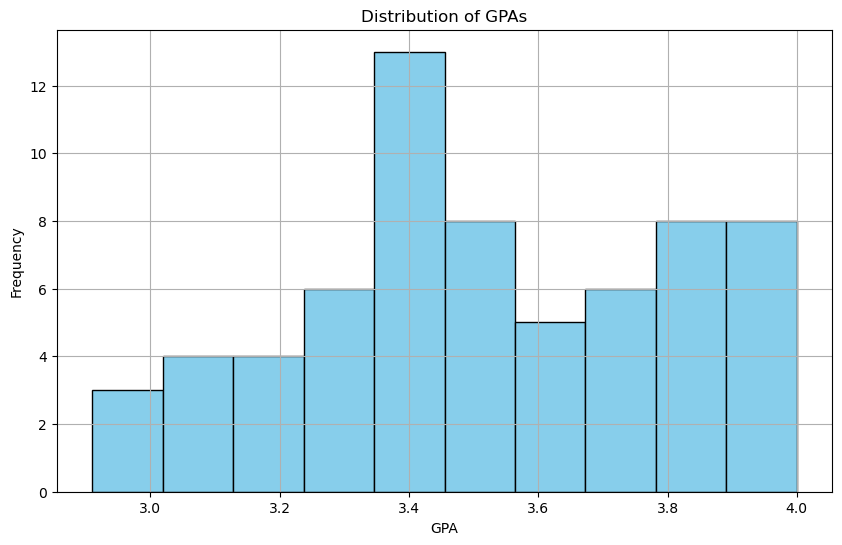

In [79]:
import matplotlib.pyplot as plt

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(gpas, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of GPAs')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

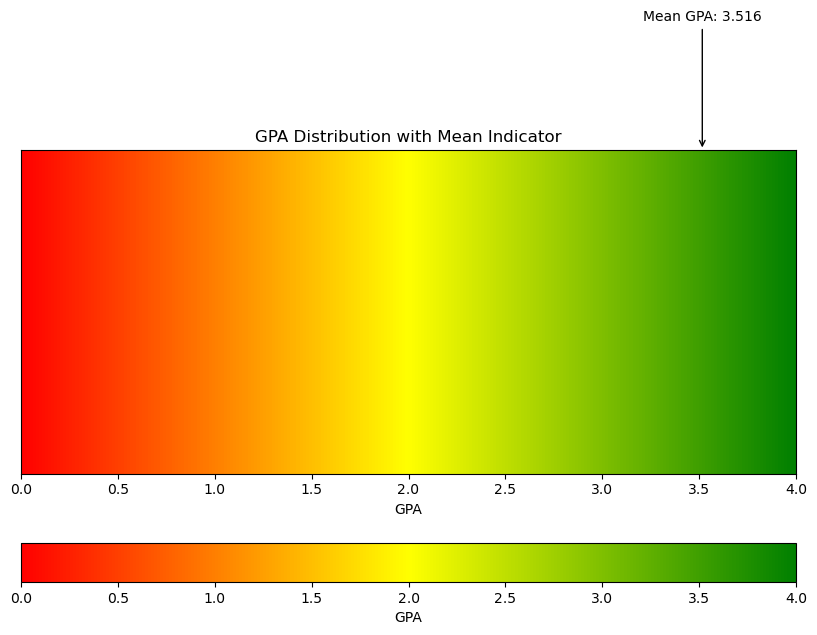

In [80]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

mean_gpa = round(np.mean(gpas), 3)
cutoff_gpa = 3.0

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the custom color gradient based on the provided information
colors = ['red', 'yellow', 'green']
cmap = LinearSegmentedColormap.from_list('custom', colors)
norm = plt.Normalize(0.0, 4.0)

# Create a horizontal color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, orientation='horizontal')
cbar.set_label('GPA')

# Plot the color gradient bar
plt.imshow(np.linspace(0, 4, 256).reshape(1, -1), cmap=cmap, aspect='auto', extent=[0, 4, 0, 0.5])

# Plot the arrow for the mean GPA
plt.annotate(f'Mean GPA: {mean_gpa}', (mean_gpa, 0.5), (mean_gpa, 0.7),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, ha='center')

# Set axis labels and title
plt.xlabel('GPA')
plt.yticks([])
plt.title('GPA Distribution with Mean Indicator')

plt.show()

In [81]:
import math

gre = ['gre_quantitative', 'gre_verbal', 'gre_writing']

gre_reported_count = df[gre].count().mean()  # Calculate the average count of GRE scores
rounded_gre_reported_count = math.ceil(gre_reported_count)  # Round up the average count
total_applicants = len(df)
gre_takers_str = f"Average GRE Takers: {rounded_gre_reported_count}/{total_applicants} applicants"
print(gre_takers_str)

Average GRE Takers: 14/72 applicants


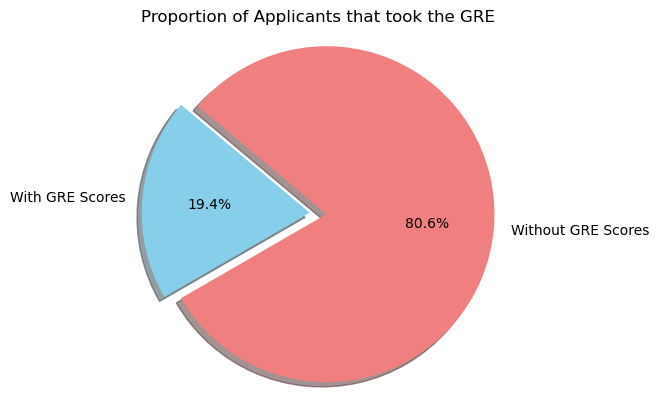

In [82]:
# Calculate the count of applicants without GRE scores
applicants_without_gre = total_applicants - rounded_gre_reported_count

# Create a pie chart
labels = ['With GRE Scores', 'Without GRE Scores']
sizes = [rounded_gre_reported_count, applicants_without_gre]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # Explode the first slice for emphasis

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.title('Proportion of Applicants that took the GRE')
plt.show()

In [83]:
# Calculate the mean scores for each section of the GRE
mean_quantitative = round(df['gre_quantitative'].mean() , 1 )
mean_verbal = round(df['gre_verbal'].mean() , 1 )
mean_writing = round(df['gre_writing'].mean() , 2)

gre_mean_scores_str = f"GRE Mean Scores by Section:\nQ: {mean_quantitative}\nV: {mean_verbal}\nW: {mean_writing}"
print(gre_mean_scores_str)

GRE Mean Scores by Section:
Q: 164.9
V: 163.6
W: 4.42


In [84]:
import math

# FYI, the math library is imported and the function ceil is used to round up to nearest whole integer if mean of rec letters comes out as a float
mean_recommendation_letters = math.ceil(df['recommendations'].mean())
mean_recommendation_letters_str = f"Average Amount of Recommendation Letters: {mean_recommendation_letters}"

print(mean_recommendation_letters_str)

Average Amount of Recommendation Letters: 2


In [85]:
df

,status,recommendations,statementOfPurpose,comments,moocs,relevantCreditCourses,institution,degree,gpa,gre_quantitative,gre_verbal,gre_writing,days_between_apply_and_decide,total_experience_in_years,statementOfPurpose_elmo,comments_elmo,moocs_elmo,relevantCreditCourses_elmo,institution_elmo,degree_elmo
0,Accepted,0,Y,"All A's for prereq's, including the ones on th...",,,Big State School,MS in Software Engineering,4.00,NaN,NaN,NaN,94,0.0,0.026066,-0.000246,NaN,NaN,-0.006192,-0.015312
1,Accepted,1,Y,I also have publications and thesis. Generally...,,,University of Minnesota,MS in Computer Science,3.70,NaN,NaN,NaN,101,6.0,0.026066,-0.006971,NaN,NaN,0.016456,-0.003990
2,Rejected,1,Y,"Got rejected, but I've already accepted an adm...",,,University of Illinois,BS in Mechanical Engineering,3.75,NaN,NaN,NaN,483,3.0,0.026066,0.003734,NaN,NaN,0.015232,-0.023936
3,Accepted,3,Y,Nervous and will need to do a lot of studying ...,,,,BS in Health Sciences,NaN,NaN,NaN,NaN,65,5.0,0.026066,-0.003599,NaN,NaN,NaN,-0.007665
4,Accepted,3,Y,My Weakness - I know my 3.92 GPA seems like a ...,,,UT Austin,BS in Data Science,3.92,NaN,NaN,NaN,36,0.0,0.026066,-0.003765,NaN,NaN,0.000995,-0.008218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Accepted,2,Talked about experience working on Stats and r...,,Coursera ML Mathematics and Python,,,BS in Mechanical Engineering,3.50,NaN,NaN,NaN,41,8.0,-0.003724,NaN,-0.004903,NaN,NaN,-0.023936
68,Accepted,3,Explained the big project I wanted to work on ...,,none,,UCSD,MS in Materials Science,3.80,NaN,NaN,NaN,49,8.0,-0.011106,NaN,-0.015951,NaN,-0.012131,-0.014360
69,Accepted,0,Explained how I am passionate about building a...,,1 - Deep Learning with PyTorch from IBM,,UT Austin,MA in Economics,3.60,160.0,168.0,4.5,114,0.0,-0.008192,NaN,0.000724,NaN,0.000995,-0.013780
70,Accepted,2,Explained how my previous experience is relate...,,Andrew NG's ML Specialization,,,BS in Mechanical Engineering,3.40,NaN,NaN,NaN,53,0.0,-0.000600,NaN,0.003513,NaN,NaN,-0.023936


In [86]:
import re

experience_values = df['total_experience_in_years']

# Drop the NaN values
experience_values = experience_values.dropna()

# Calculate the average, in years, of the extracted values
mean_experience = experience_values.mean()
median_experience = experience_values.median()

# Convert mean experience to years and months
mean_years = math.floor(mean_experience)
mean_months = round((mean_experience - mean_years) * 12)

# Convert median experience to years and months
median_years = math.floor(median_experience)
median_months = round((median_experience - median_years) * 12)

# Print the mean and median experience in years and months
mean_experience_str = f"Mean Experience: {mean_years} years {mean_months} months"
median_experience_str = f"Median Experience: {median_years} years {median_months} months"

print(mean_experience_str)
print(median_experience_str)

Mean Experience: 3 years 3 months
Median Experience: 2 years 0 months


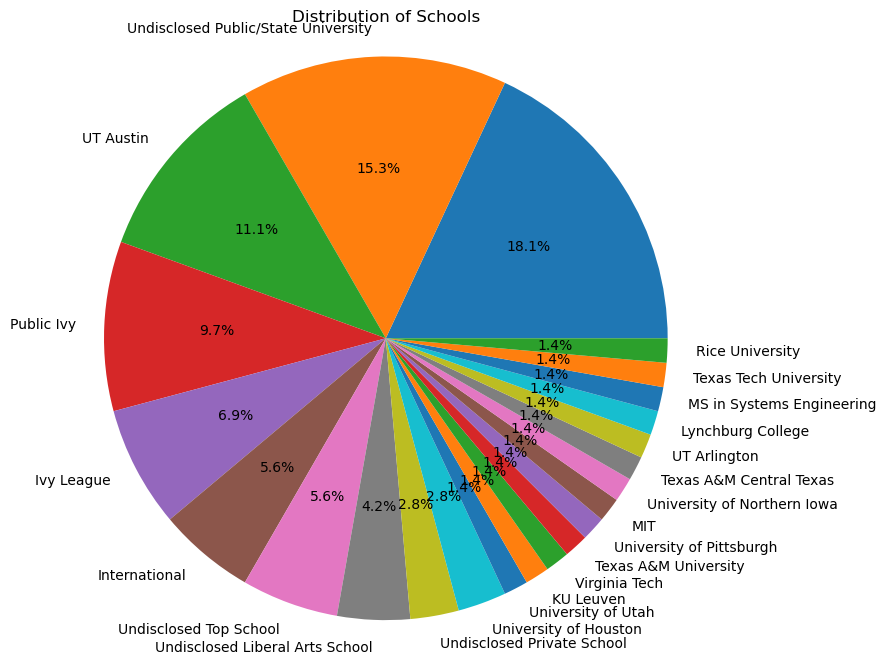

In [87]:
import re

school_names = df['institution']

# Modify the school names to group specific schools
school_names_modified = school_names.copy()

# Group "Columbia University" and "Yale University" and "Harvard University" under "Ivy League"
school_names_modified = [name if name not in ["Columbia University", "Yale University", "Harvard University"] else "Ivy League" for name in school_names_modified]
# Group schools with "state" or "public" in the name under "Undisclosed Public/State University"
school_names_modified = [name if isinstance(name, str) and ("public" not in name.lower() and "state" not in name.lower()) else "Undisclosed Public/State University" for name in school_names_modified]
# Group schools with "Top" or "Great" in the name under "Undisclosed Top School"
school_names_modified = [name if isinstance(name, str) and ("top" not in name.lower() and "great" not in name.lower()) else "Undisclosed Top School" for name in school_names_modified]
# Group schools with "liberal arts" in the name under "Undisclosed Liberal Arts School"
school_names_modified = [name if isinstance(name, str) and "liberal arts" not in name.lower() else "Undisclosed Liberal Arts School" for name in school_names_modified]
# Group schools with "private" in the name under "Undisclosed Private School"
school_names_modified = [name if isinstance(name, str) and "private" not in name.lower() else "Undisclosed Private School" for name in school_names_modified]
# Group schools with "Tec de Monterrey", "Canadian", "Waterloo", "overseas" in the name under "International"
school_names_modified = [name if isinstance(name, str) and not any(keyword in name.lower() for keyword in ["tec de monterrey", "canadian", "waterloo", "overseas"]) else "International" for name in school_names_modified]
# Group schools certain schools as "Public Ivy"
school_names_modified = [name if isinstance(name, str) and not any(keyword in name.lower() for keyword in ["ucsd", "georgia institute of technology", "university of washington", "university of illinois", "illinois", "minnesota", "maryland"]) else "Public Ivy" for name in school_names_modified]

# Filter out responses to get a single institution entry
school_names_cleaned = [name for name in school_names_modified if not isinstance(name, list)]

# Count the occurrences of each school
school_counts = pd.Series(school_names_cleaned).value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(school_counts.values, labels=school_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Schools')
plt.axis('equal')
plt.show() 


# Testing, Training, Class Imbalance, and Random Forest Classifier

In [153]:
df

,status,recommendations,statementOfPurpose,comments,moocs,relevantCreditCourses,institution,degree,gpa,gre_quantitative,gre_verbal,gre_writing,days_between_apply_and_decide,total_experience_in_years,statementOfPurpose_elmo,comments_elmo,moocs_elmo,relevantCreditCourses_elmo,institution_elmo,degree_elmo
0,Accepted,0,Y,"All A's for prereq's, including the ones on th...",,,Big State School,MS in Software Engineering,4.00,NaN,NaN,NaN,94,0.0,0.026066,-0.000246,NaN,NaN,-0.006192,-0.015312
1,Accepted,1,Y,I also have publications and thesis. Generally...,,,University of Minnesota,MS in Computer Science,3.70,NaN,NaN,NaN,101,6.0,0.026066,-0.006971,NaN,NaN,0.016456,-0.003990
2,Rejected,1,Y,"Got rejected, but I've already accepted an adm...",,,University of Illinois,BS in Mechanical Engineering,3.75,NaN,NaN,NaN,483,3.0,0.026066,0.003734,NaN,NaN,0.015232,-0.023936
3,Accepted,3,Y,Nervous and will need to do a lot of studying ...,,,,BS in Health Sciences,NaN,NaN,NaN,NaN,65,5.0,0.026066,-0.003599,NaN,NaN,NaN,-0.007665
4,Accepted,3,Y,My Weakness - I know my 3.92 GPA seems like a ...,,,UT Austin,BS in Data Science,3.92,NaN,NaN,NaN,36,0.0,0.026066,-0.003765,NaN,NaN,0.000995,-0.008218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Accepted,2,Talked about experience working on Stats and r...,,Coursera ML Mathematics and Python,,,BS in Mechanical Engineering,3.50,NaN,NaN,NaN,41,8.0,-0.003724,NaN,-0.004903,NaN,NaN,-0.023936
68,Accepted,3,Explained the big project I wanted to work on ...,,none,,UCSD,MS in Materials Science,3.80,NaN,NaN,NaN,49,8.0,-0.011106,NaN,-0.015951,NaN,-0.012131,-0.014360
69,Accepted,0,Explained how I am passionate about building a...,,1 - Deep Learning with PyTorch from IBM,,UT Austin,MA in Economics,3.60,160.0,168.0,4.5,114,0.0,-0.008192,NaN,0.000724,NaN,0.000995,-0.013780
70,Accepted,2,Explained how my previous experience is relate...,,Andrew NG's ML Specialization,,,BS in Mechanical Engineering,3.40,NaN,NaN,NaN,53,0.0,-0.000600,NaN,0.003513,NaN,NaN,-0.023936


In [155]:
drop_cols = ['status', 'statementOfPurpose','comments','moocs','relevantCreditCourses','institution','degree', 'statementOfPurpose_elmo','comments_elmo','moocs_elmo','relevantCreditCourses_elmo','institution_elmo','degree_elmo']

# Separate features (X) and target variable (y)
X = df.drop(drop_cols, axis=1)
y = df['status']

In [156]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to fill in missing values
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_res, y_res = smote.fit_resample(X_train_imputed, y_train)

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Create a Bagging classifier with the Random Forest classifier
bag_clf = BaggingClassifier(rf_clf, n_estimators=100, random_state=42)

# Fit the classifier to the resampled data
bag_clf.fit(X_res, y_res)

# Predict the labels for the test set
y_pred = bag_clf.predict(X_test_imputed)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Accepted       0.92      0.92      0.92        12
    Rejected       0.67      0.67      0.67         3

    accuracy                           0.87        15
   macro avg       0.79      0.79      0.79        15
weighted avg       0.87      0.87      0.87        15



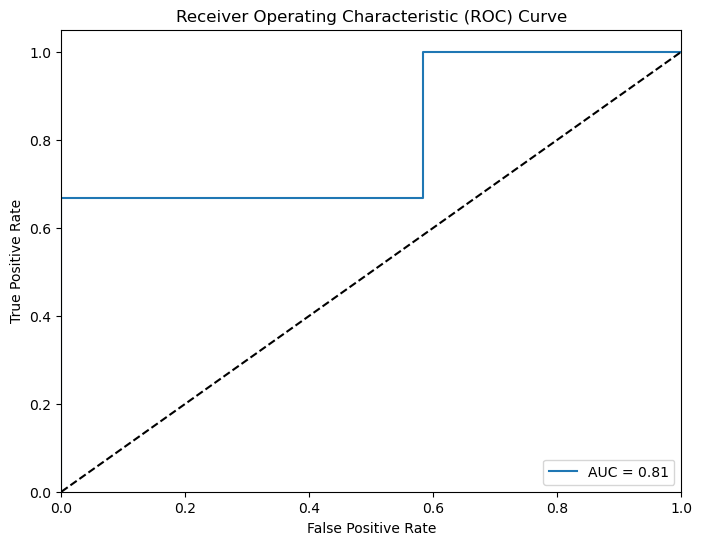

In [157]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = bag_clf.predict_proba(X_test_imputed)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob)
auc = roc_auc_score(y_test_encoded, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [158]:
# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Fit the classifier to the resampled data
rf_clf.fit(X_res, y_res)

# Get feature importances
importances = rf_clf.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, X.columns)

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

print(f_importances)

days_between_apply_and_decide    0.322862
total_experience_in_years        0.206350
gpa                              0.190094
recommendations                  0.132434
gre_writing                      0.054770
gre_quantitative                 0.047944
gre_verbal                       0.045547
dtype: float64


# Post-Model Visualizations

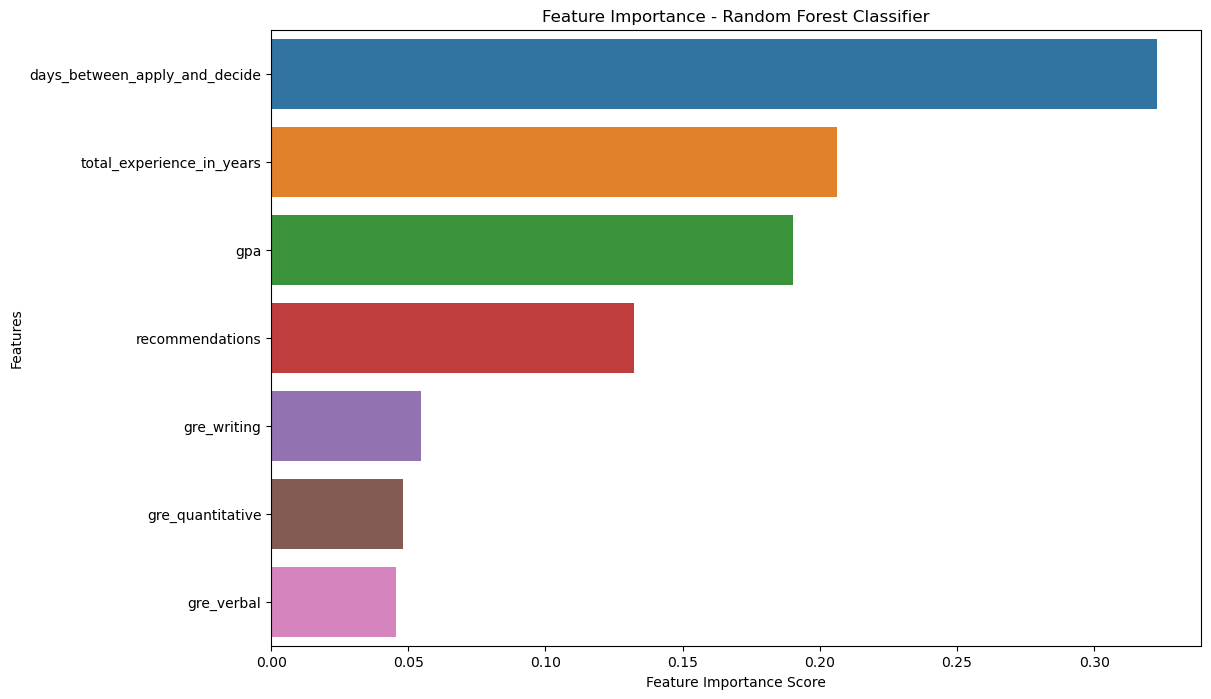

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf_clf.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, X.columns)

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

# Make the bar Plot from f_importances
plt.figure(figsize=(12,8))
sns.barplot(x=f_importances, y=f_importances.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest Classifier')
plt.show()

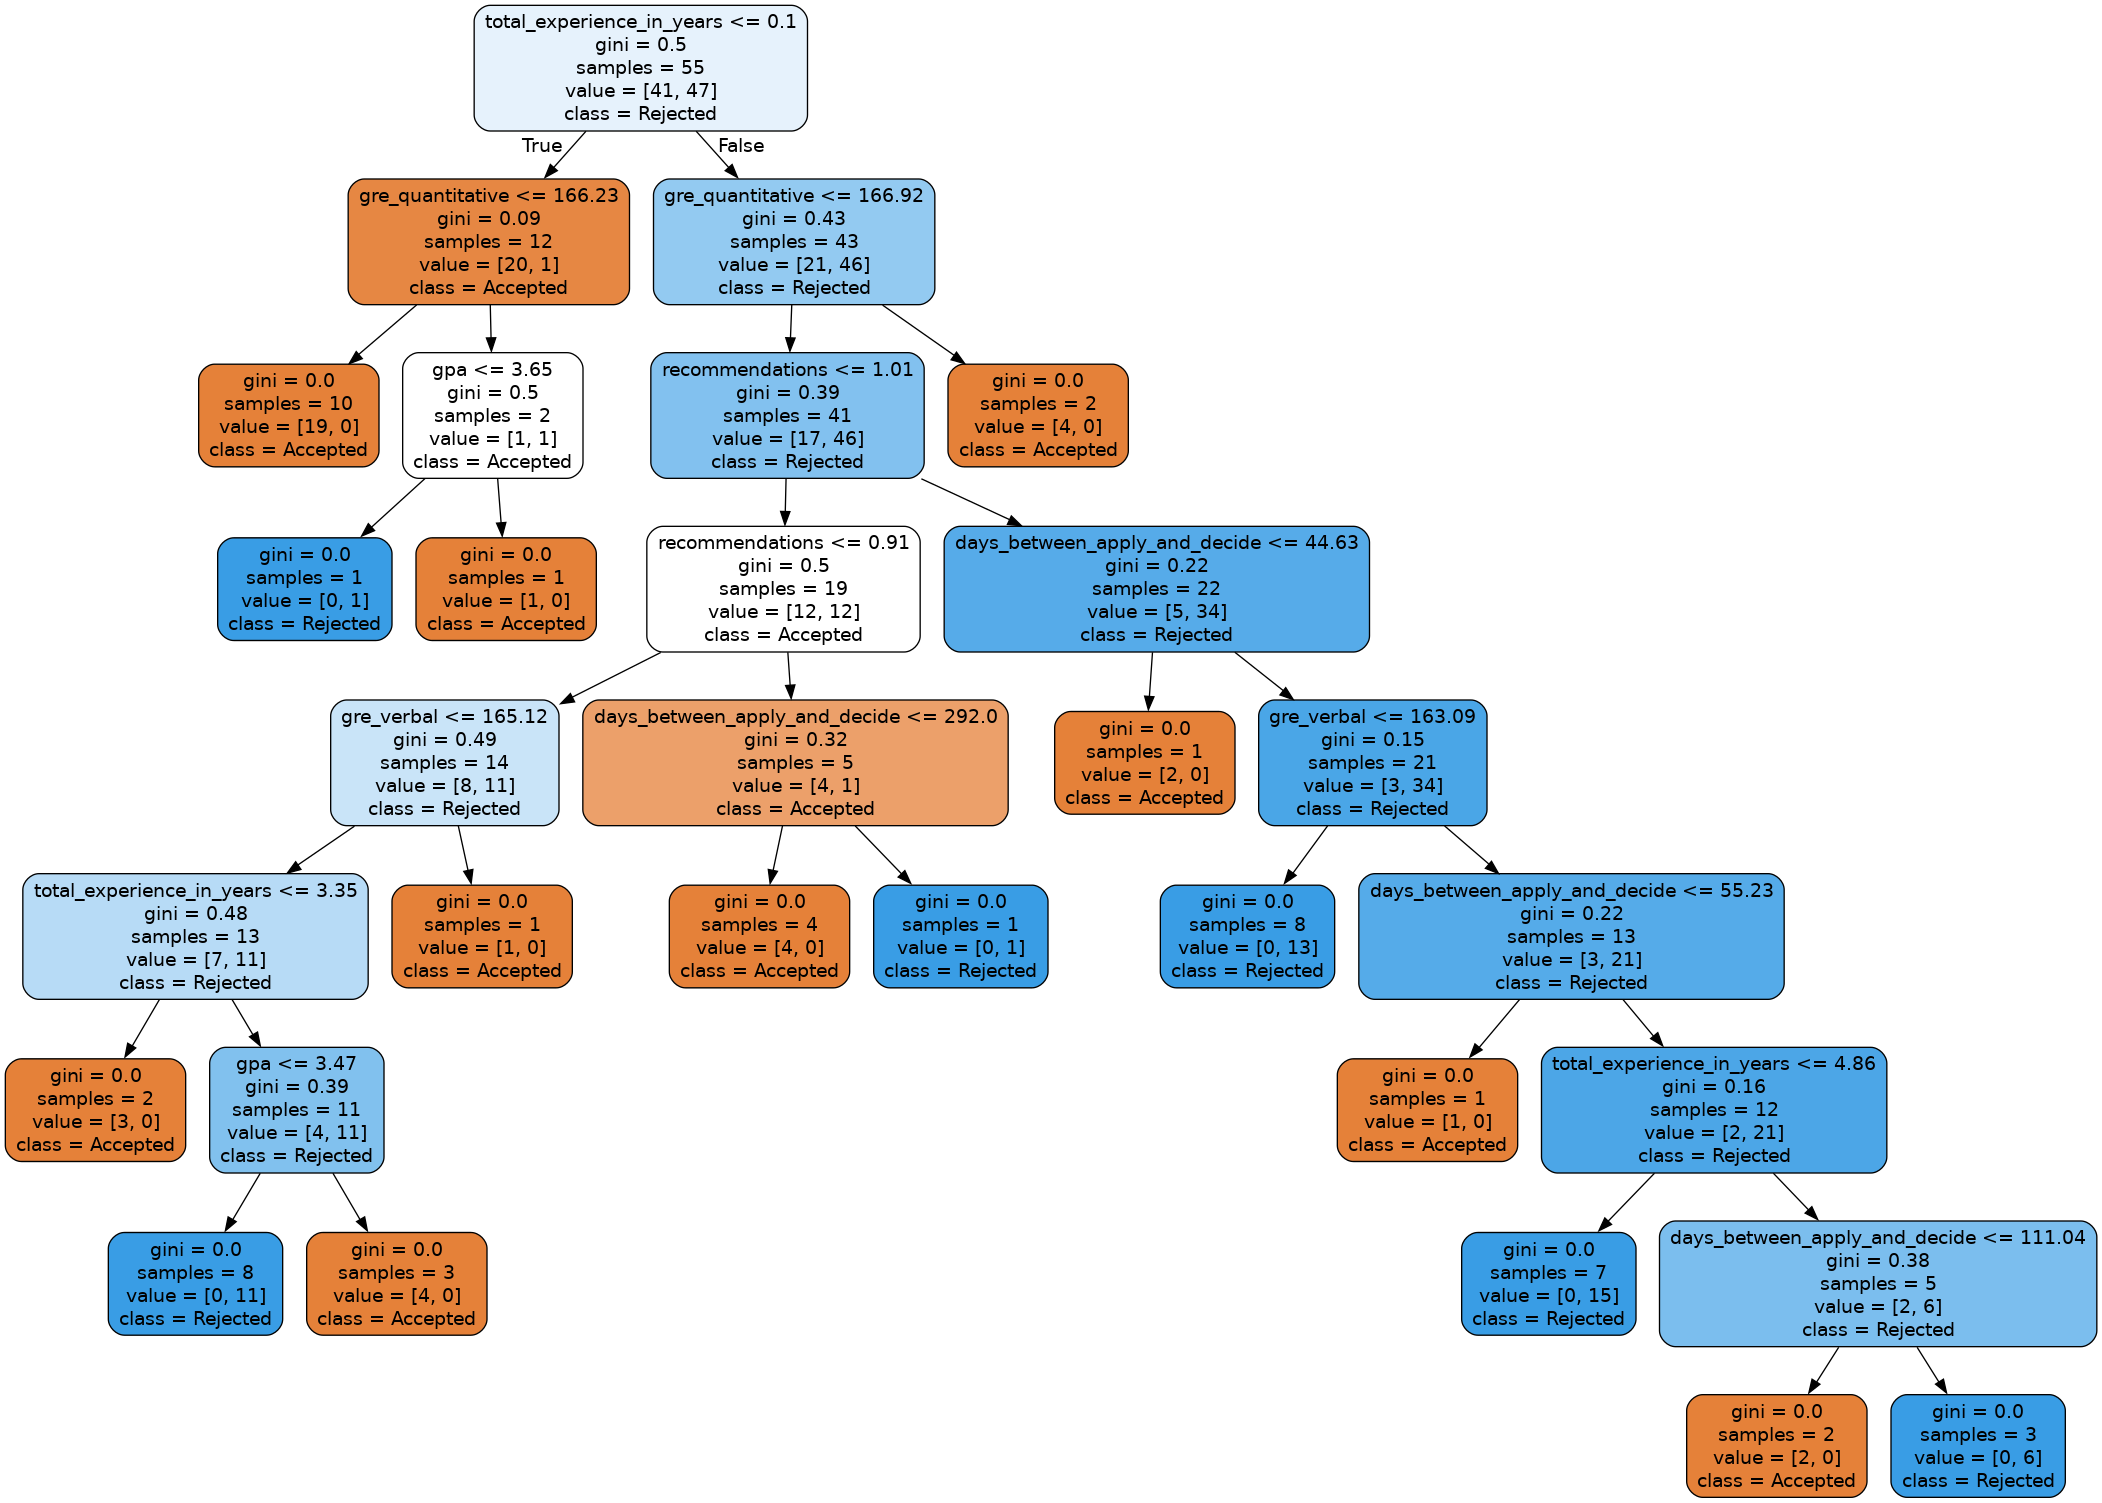

In [160]:
# Suppose rf_clf is your trained RandomForestClassifier
# Get the first tree within the "ensemble" of trees
estimator = rf_clf.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = X.columns,
                class_names = y.unique(),
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
import os
os.system('dot -Tpng tree.dot -o tree.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Future Improvements
1. Better ways of dealing with class imbalance. Numerous techniques attempted, i.e. SMOTE, Random Under/oversampling.

  * Considering the possibility of waiting for more semester admission   threads: simply gathering more data to improve the performance of the model


2. Modify loss function to penalize False Positives and False Negatives with different magnitudes.i.e. if simple Cross Entropy is:

$$\frac{-1}{N} \sum_{i=1}^Ny_i \cdot \log(\hat{y_i}) + (1 - y_i) \cdot \log(1 - \hat{y_i})$$

Where:
* $y_i \cdot \log(\hat{y_i})$ penalizes False Negatives
* $(1 - y_i) \cdot \log(1 - \hat{y_i})$ penalizes False Positives

We could introduce some new scalar parameters to change the size or influence of these.